In [1]:
#@title Importing Packages

# Utility
import math as math
import numpy as np
import pandas as pd
import random as rdm
import scipy.io as io
import scipy.stats as stats
from google.colab import drive
import networkx as nx

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.animation import FuncAnimation
from functools import partial

# Binomial

In [2]:
def findMode(sample):

    mode = 0
    count = 0
    for value in set(sample):
        countValue = sum([1 for num in sample if num == value])
        if countValue >= count:
            mode = value
            count = countValue
    
    return mode, count


In [3]:
#@title Function to plot pdf of distribution

def plotPDF(dist, mean, true):

    sample = dist.rvs(10000)
    plt.hist(sample, bins = int(len(sample)/100), alpha = 0.5)

    plt.scatter(mean, 0, s = 100, c = 'r', label = 'Mean')
    plt.scatter(true, 0, s = 100, c = 'g', label = 'True value')

    plt.legend()
    plt.show()



In [4]:
#@title function to plot walk of single parameter

def plotWalk(sample, true):

    plt.plot(range(len(sample)), sample)
    plt.plot([0, len(sample)], [true, true], label = 'True value')
    plt.legend()
    plt.show()

The true value of p is 0.259


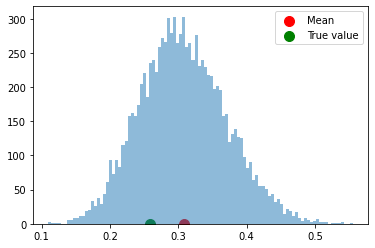

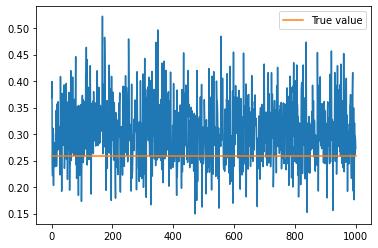

In [5]:
#@title Gibbs sampler for binomial distribution
pTrue = stats.uniform.rvs()

likelihood = stats.binom(1, pTrue)
sample = likelihood.rvs(rdm.randint(0, 100))

a = 1
b = 1

n = len(sample)
y = sum(sample)

a = a + y
b = b + n - y

prior = stats.beta(a, b)
pSample = [prior.rvs()]

for i in range(1000):

    mean = a/(a + b)
    posterior = stats.beta(a, b)
    pSample.append(posterior.rvs())

print(f"The true value of p is {format(pTrue, '.3f')}")
plotPDF(posterior, mean, pTrue)
plotWalk(pSample, pTrue)

In [6]:
stats.binom(1, pTrue).pmf(1)

0.25855160469135297

In [7]:
#@title Metropolis-Hastings for binomial - Working?
pTrue = stats.uniform.rvs()

likelihood = stats.binom(1, pTrue)
sample = likelihood.rvs(100)

a = 1 + sum(sample)
b = 1 + len(sample) - sum(sample)
ybar = np.mean(sample)

prior = stats.beta(a, b)
pSample = [prior.rvs()]

xNaught = stats.uniform(0, 1).rvs()
S = 10000
posterior = np.zeros((S,))

for t in range(S):
    posterior[t] = xNaught

    x = stats.uniform.rvs() 

    p1 = prior.pdf(x)
    p2 = prior.pdf(xNaught)

    #print(f"Values: {x}, {xNaught}")
    #print(f"p: {p1}, {p2}")

    alpha = p1/p2
    u = stats.uniform(0, 1).rvs()

    if u < alpha:
        print(f"Accepted: {t}")
        xNaught = x # accept
    #print("")


Streaming output truncated to the last 5000 lines.

Values: 0.5091353367612411, 0.08901188881968414
p: 3.1418696029353904e-18, 13.957025826430778

Values: 0.45264425563526534, 0.08901188881968414
p: 2.7599815898660485e-14, 13.957025826430778

Values: 0.3560800742919922, 0.08901188881968414
p: 1.2558922601037814e-08, 13.957025826430778

Values: 0.8095864348823557, 0.08901188881968414
p: 1.872193112022828e-54, 13.957025826430778

Values: 0.1052119800275706, 0.08901188881968414
p: 10.205066591251342, 13.957025826430778
Accepted: 8384

Values: 0.14286513460636074, 0.1052119800275706
p: 2.259291954415827, 10.205066591251342

Values: 0.820844722482147, 0.1052119800275706
p: 7.678057033786381e-57, 10.205066591251342

Values: 0.4387006548506259, 0.1052119800275706
p: 2.1741175745153026e-13, 10.205066591251342

Values: 0.27678080514017356, 0.1052119800275706
p: 7.310752907419369e-05, 10.205066591251342

Values: 0.7649834988822647, 0.1052119800275706
p: 3.050034920686905e-46, 10.205066591251342


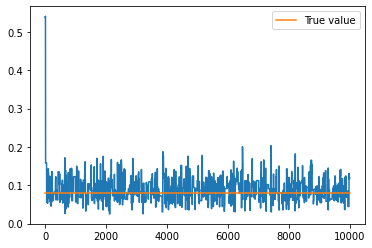

In [8]:
plotWalk(posterior, ybar)

(array([ 115.,  316.,  474., 1516., 1308., 1593., 1329., 1031.,  903.,
         557.,  368.,  170.,  166.,   62.,   54.,   16.,    6.,    7.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    3.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    6.]),
 array([0.02540339, 0.03571598, 0.04602856, 0.05634115, 0.06665373,
        0.07696632, 0.0872789 , 0.09759149, 0.10790407, 0.11821666,
        0.12852924, 0.13884183, 0.14915441, 0.159467  , 0.16977958,
        0.18009217, 0.19040475, 0.20071734, 0.21102992, 0.22134251,
        0.23165509, 0.24196768, 0.25228026, 0.26259285, 0.27290543,
        0.28321802, 0.2935306 , 0.30384319, 0.31415577, 0.32446836,
        0.33478094, 0.34509352, 0.35540611, 0.36571869, 0.37603128,
        0.38634386, 0.39665645, 0.40696903, 0.41728162, 0.4275942 ,
        0.43790679, 0.44821937, 0.45853196, 0.46884454, 

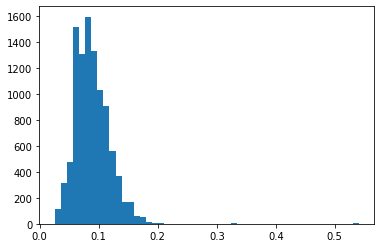

In [9]:
plt.hist(posterior, bins = 50)

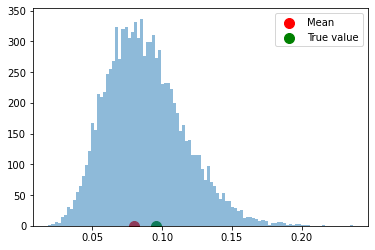

In [10]:
plotPDF(prior, ybar, pTrue)

# Normal

In [11]:
#@title Replicating R's variance function

def variance(sample):

    var = np.var(sample)*n/(n - 1)

    return var

## Gibbs Sampler

In [36]:
#@title Gibbs Sampler for normal distribution - Mu working, Sigma squared working?

# Initial sample
y = [1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08]
n = len(y) 
ybar = np.mean(y)
s2 = variance(y)

print(ybar, s2)

# Prior
mu0 = 1.9
kappa0 = 1
t20 = (mu0/stats.norm.ppf(0.975))
s20 = 0.01
nu0 = 1

print(mu0, s20)
# Initialising array
S = 10000
phi = [ybar, s2]
PHI = np.zeros((S, 2))
PHI[0, :] = phi

rdm.seed(1)
for s in range(1, S):

    mun = (mu0/t20 + n*ybar/phi[1])/(1/t20 + n/phi[1])
    t2n = 1/(1/t20 + n/phi[1])

    phi[0] = stats.norm(mun, np.sqrt(t2n)).rvs(1)

    # Sample sigmaˆ2 from its full conditional based on theta

    nun = nu0 + n
    kappan = kappa0 + n
    s2n = (nu0*s20 + (n - 1)*s2 + n*(ybar - phi[0])**2)/nun

    # This posterior distribution: inverse-gamma(nu_n/2,sigmaˆ2_n(\theta)
    phi[1] = stats.invgamma(nun/2, scale = s2n*nun/2).rvs(1)

    PHI[s, :] = phi


1.8044444444444447 0.016877777777777787
1.9 0.01


<ipython-input-36-8f4524492820>:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  PHI[s, :] = phi


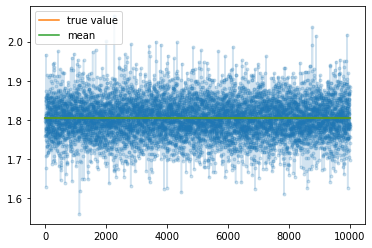

In [37]:
#@title Plotting walk of mean

plt.plot(range(10000), PHI[:, 0], '.-', alpha = 0.2)
plt.plot([0, 10000], [ybar, ybar], label = 'true value')
plt.plot([0, 10000], [np.mean(PHI[:, 0]), np.mean(PHI[:, 0])], label = 'mean')

plt.legend()

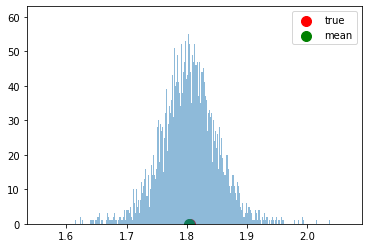

In [38]:
#@title Plotting histogram of mean

plt.hist(PHI[:, 0], bins = 1000, alpha = 0.5)
plt.scatter(ybar, 0, s = 100, c = 'r', label = 'true')
plt.scatter(np.mean(PHI[:, 0]), 0, s = 100, c = 'g', label = 'mean')

plt.legend()

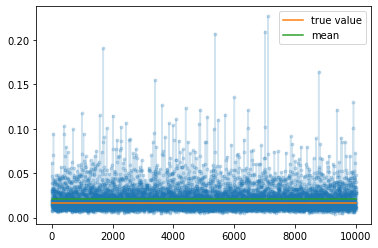

In [39]:
#@title Plotting walk of sigma-squared

plt.plot(range(10000), (PHI[:, 1]), '.-', alpha = 0.2)
plt.plot([0, 10000], [s2, s2], label = 'true value')
plt.plot([0, 10000], [np.mean(PHI[:, 1]), np.mean(PHI[:, 1])], label = 'mean')

plt.legend()

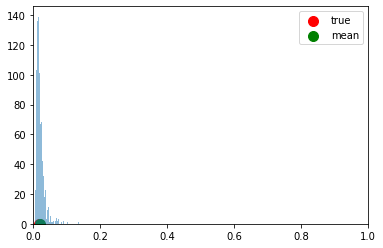

In [40]:
#@title Plotting histogram of sigma-squared

plt.hist((PHI[:, 1]), bins = 1000, alpha = 0.5)
plt.scatter(s2, 0, s = 100, c = 'r', label = 'true')
plt.scatter(np.mean((PHI[:, 1])), 0, s = 100, c = 'g', label = 'mean')
plt.xlim(0, 1)
plt.legend()

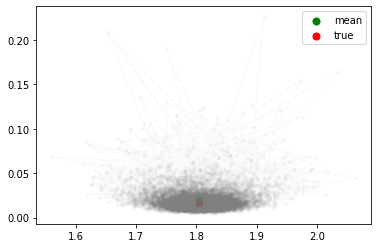

In [41]:
#@title Plotting mean vs sigma-squared

plt.scatter(np.mean(PHI[:, 0]), np.mean(PHI[:, 1]), s = 50, c = 'g', label = 'mean')
plt.plot(PHI[:, 0], PHI[:, 1], '.-', alpha = 0.04, c = 'grey')
plt.scatter(ybar, s2, s = 50, c = 'r', label = 'true')

plt.legend()

## Metropolis-hastings

In [19]:
#@title Metropolis-Hastings for normal - Mu working, sigma-squared working?

# Intiialising likelihood distribution
muL = stats.uniform(1, 7).rvs()
s2L = stats.uniform(0, 0.1).rvs()
likelihood = stats.norm(muL, np.sqrt(s2L))

# Initialising sample
sample = likelihood.rvs(5)
n = len(sample)
ybar = np.mean(sample)
s2 = variance(sample)

print(ybar, s2)

# Initialising prior values
mu0 = stats.uniform(1, 7).rvs()
kappa0 = 1
t20 = (mu0/stats.norm.ppf(0.975))
s20 = 0.01
nu0 = 1

S = 10000
phi = [ybar, s2]

PHI = np.zeros((S, 2))
PHI[0, :] = [mu0, s20]

for t in range(S):
    sample = likelihood.rvs(int(stats.uniform(50, 100).rvs()))
    n = len(sample)
    ybar = np.mean(sample)
    s2 = variance(sample)

  # Get starting probabilities for prior values of mu and sigma
    # Mu
    
    mun = (mu0/t20 + n*ybar/phi[1])/(1/t20 + n/phi[1])
    t2n = 1/(1/t20 + n/phi[1])
    pPriorMu = stats.norm(mun, np.sqrt(t2n)).pdf(mu0)

    # Sigma
    nun = nu0 + n
    kappan = kappa0 + n
    s2n = (nu0*s20 + (n - 1)*s2 + n*(ybar - phi[0])**2)/nun
    pPriorS2 = stats.invgamma(nun/2, scale = s2n*nun/2).pdf(s20)

    # Candidates
    # Candidate for mu
    mu = stats.norm(mu0).rvs() # candidate
    sigma2 = stats.norm(s20).rvs()

    pCandidateMu = stats.norm(mun, np.sqrt(t2n)).pdf(mu)
    #print("Mu:")
    #print("Values: ", mu0, mu)
    #print("Probabilities: ", pCandidateMu, pPriorMu)
    
    alpha = pCandidateMu/pPriorMu
    u = stats.uniform(0, 1).rvs() # random uniform

    if u < alpha:
        mu0 = mu # accept

    #print("")

    # Candidate for sigma-squared

    pCandidateS2 = stats.invgamma(nun/2, scale = s2n*nun/2).pdf(sigma2)
    #print("Sigma-Squared:")
    #print("Values: ", s20, sigma2)
    #print("Probabilities: ", pCandidateS2, pPriorS2)
    
    beta = pCandidateS2/pPriorS2 # ratio
    u = stats.uniform(0, 1).rvs() # random uniform

    if u < beta:
        s20 = sigma2 # accept

    #print("")

    PHI[t, :] = [mu0, s20]
    #print("")

2.3812636103611475 0.03104798676698415
Mu:
Values:  4.5312756676723085 4.979875622125192
Probabilities:  0.0 0.0

Sigma-Squared:
Values:  0.01 -0.9797615413093508
Probabilities:  0.0 2.2144819834033208e-139


Mu:
Values:  4.5312756676723085 4.626737893359768
Probabilities:  0.0 0.0

Sigma-Squared:
Values:  0.01 2.4140204032096135
Probabilities:  4.226712296076823e-76 1.7729626947534208e-178


Mu:
Values:  4.5312756676723085 4.038284038739434
Probabilities:  0.0 0.0

Sigma-Squared:
Values:  2.4140204032096135 3.7627654556524144
Probabilities:  9.973428487438401e-29 1.749919579319345e-23


Mu:
Values:  4.5312756676723085 4.4576351673056065
Probabilities:  0.0 0.0

Sigma-Squared:
Values:  2.4140204032096135 3.804698324596004
Probabilities:  2.9383952899781576e-77 5.6269799325049336e-65


Mu:
Values:  4.5312756676723085 4.406031480214866
Probabilities:  0.0 0.0

Sigma-Squared:
Values:  2.4140204032096135 3.0974014045293967
Probabilities:  1.7520802666204175e-58 1.4786543331344501e-52


Mu:

<ipython-input-19-63eb364266a5>:58: RuntimeWarning: invalid value encountered in double_scalars
  alpha = pCandidateMu/pPriorMu
<ipython-input-19-63eb364266a5>:58: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = pCandidateMu/pPriorMu


Streaming output truncated to the last 5000 lines.
Sigma-Squared:
Values:  0.11681698969903401 0.11267450542777227
Probabilities:  16.112884464430554 11.102136104081605


Mu:
Values:  2.4027337751721607 2.127864112735417
Probabilities:  2.3143457300133632e-30 17.229574864337206

Sigma-Squared:
Values:  0.11267450542777227 -0.21897055750049751
Probabilities:  0.0 0.0046233529971764255


Mu:
Values:  2.4027337751721607 2.205204118441094
Probabilities:  2.184855898499584e-38 0.0005481803479998484

Sigma-Squared:
Values:  0.11267450542777227 -1.3811652565236199
Probabilities:  0.0 11.23960060430965


Mu:
Values:  2.4027337751721607 3.704510013048199
Probabilities:  0.0 0.0002648550010695079

Sigma-Squared:
Values:  0.11267450542777227 -0.2547214620788315
Probabilities:  0.0 7.025045872427555


Mu:
Values:  2.4027337751721607 1.4847482894859727
Probabilities:  0.0 1.798172740089065

Sigma-Squared:
Values:  0.11267450542777227 1.3505388797604745
Probabilities:  1.4518387160602938e-31 1.69420

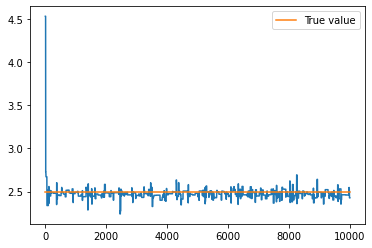

In [35]:
#@title Plotting walk of Mean

plotWalk(PHI[:, 0], ybar)

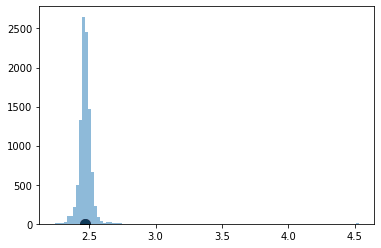

In [33]:
#@title Plotting histogram of mean samples

plt.hist(PHI[:, 0], bins = 100, alpha = 0.5)
plt.scatter(np.mean(PHI[:,0]), 0, s = 100, c = 'r')
plt.scatter(muL, 0, s = 100, c = 'k')

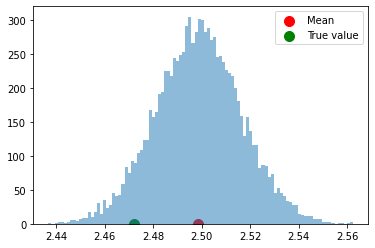

In [28]:
#@title Plotting pdf of mean posterior

plotPDF(stats.norm(mun, np.sqrt(t2n)), ybar, muL)

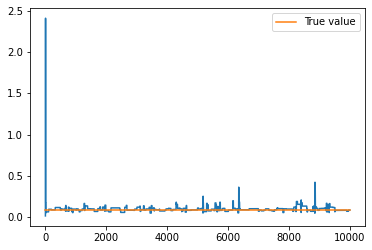

In [32]:
#@title Plotting walk of sigma-squared

plotWalk(PHI[:, 1], s2L)

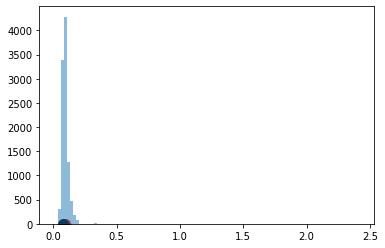

In [31]:
#@title Plotting histogram of sigma-squared samples

plt.hist(PHI[:, 1], bins = 100, alpha = 0.5)
plt.scatter(np.mean(PHI[:,1]), 0, s = 100, c = 'r')
plt.scatter(s2L, 0, s = 100, c = 'k')

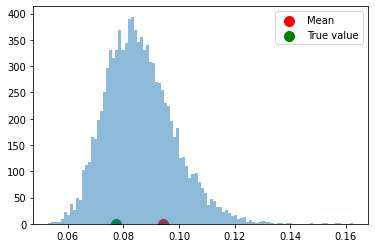

In [30]:
#@title Plotting pdf of sigma-squared posterior

plotPDF(stats.invgamma(nun/2, scale =  nun*s2n/2), np.mean(PHI[:,1]), s2L)

In [ ]:
#@title Plotting mean vs sigma-squared

plt.scatter(np.mean(PHI[:, 0]), np.mean(PHI[:, 1]), s = 50, c = 'g', label = 'mean')
plt.plot(PHI[:, 0], PHI[:, 1], '.-', alpha = 0.04, c = 'grey')
plt.scatter(ybar, s2, s = 50, c = 'r', label = 'true')

plt.legend()

# Toy example for algae bloom

In [25]:
drive.mount('drive')

pmatRaw = pd.read_csv("https://drive.google.com/uc?export=download&id=18qzQ-2TRETglAGLSXRZekyQqK7QxXUff")
pmat = pmatRaw.copy()
pmat = pmat.set_index('Unnamed: 0')

MessageError: ignored

In [ ]:
def findMNew(M, i, t, A, Alpha, Beta, StartBloom, S, pmat):

  start = S*StartBloom
  growth = Alpha*A*M[i]
  transport = Beta*sum(pmat.iloc[i, :]*M)
  MNew = start + growth + transport

  return MNew

In [ ]:
def runSimulation(sites, length, pmat):

    Alpha = 3
    Beta = 0.5

    N =  1
    A = np.zeros((length, sites))

    for n in range(N):
        i = int(stats.uniform.rvs(0, sites))
        T = int(stats.uniform.rvs(0, length))
        W = int(stats.nbinom.rvs(6, 0.75))

        A[range(T, (min(T + W, length))), i] = 1

    S = np.zeros(sites)
    M = np.zeros(sites)
    MArray = np.zeros((sites, length))

    print(f"Alpha: {Alpha}")
    print(f"Beta: {Beta}")
    print(f"T: {T}")
    print(f"W: {W}")

    for t in range(length):
      for i in range(sites):

        if A[t, i] - A[max(t - 1, 0), i] == 1:
          StartBloom = 1
          print(f"Week {t} - Bloom started at site {i}")
          S[i] = stats.gamma.rvs(1, 1)
          print(f"S = {S[i]}")
        else:
          StartBloom = 0

        M[i] = findMNew(M, i, t, A[t, i], Alpha, Beta, StartBloom, S[i], pmat.iloc[:sites, :sites])
        MArray[i, t] = M[i]

    return MArray

alpha = growth parameter
beta = decay parameter
S = Size parameter
T  = Start time parameter
W = Length of time parameter


In [ ]:
plt.hist(runSimulation(1, 100, pmat)[0], 1, 1)

In [ ]:
bigArr = []
for s in range(1000):
    arr = runSimulation(1, 100, pmat)
    bigArr.append(arr)

bigArrValue = 0
bigArrMean = np.zeros((100,))
for i in range(100):
    for s in range(1000):
        arr = bigArr[s][0]
        bigArrValue += arr[i]
    bigArrMean[i] = bigArrValue/1000

In [ ]:
#@title Gibbs sampler - Not even close

sample = runSimulation(1, 100, pmat)

n = len(sample)
ysum = sum(sample[0, :])
ybar = np.mean(sample)
s2 = variance(sample)

# Prior parameters
alphaA0 = 1
alphaB0 = 1
alphaPrior = stats.gamma(alphaA0, alphaB0)
alpha0 = alphaPrior.rvs()

betaA0 = 1
betaB0 = 1
betaPrior = stats.beta(betaA0, betaB0)
beta0 = betaPrior.rvs()

TA0 = 0
TB0 = 100
TPrior = stats.uniform(TA0, TB0)
T0 = int(TPrior.rvs())

WA0 = 1
WB0 = 1
WPrior = stats.beta(WA0, WB0)
W0 = int(WPrior.rvs())

SA0 = 1
SB0 = 1
SPrior = stats.gamma(SA0, SB0)
S0 = SPrior.rvs()


phi = [alpha0, beta0, T0, W0, S0]
S = 10000
PHI = np.zeros((10000, len(phi)))
PHI[0, :] = phi

alphaArray = np.zeros((10000,))
alphaArray[0] = alpha0

for s in range(1, S):
    
    alphaA = alphaA0 + ysum
    alphaB = alphaB0 + n

    phi[0] = stats.gamma(alphaA, alphaB).rvs()

    alphaArray[s] = phi[0]
    

In [ ]:
plotPDF(stats.gamma(np.argmax(sample) - max([i for i in range(100) if sample[0][i] == 0]), np.argmax(sample)), 1, 1)

In [ ]:
plt.plot(range(10000), alphaArray)